## 🌐 Connect to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/
%cd [2024-2025] AN2DL Homework 1/

Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/[2024-2025] AN2DL Homework 1


## 🛠 Fix Codabench Dependencies

In [2]:
# Creates a file in which we specify the versions of the libraries we want
%%writefile requirements.txt
tensorflow==2.17.0
keras==3.4.1

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1


## ⚙️ Import Libraries

In [4]:
import numpy as np
import logging

import tensorflow as tf
import keras as tfk
from keras import layers as tfkl

# Import other libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seeds for NumPy and TensorFlow
seed = 29
np.random.seed(seed)
tf.random.set_seed(seed);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## ⏳ Load and Clean the Data

In [5]:
# Load the dataset
data = np.load('training_set.npz')

# Put images on X and labels on y
X = data['images']
y = data['labels']

print("Initial X shape: ", X.shape)
print("Initial y shape: ", y.shape)

# Delete wrong images from dataset
delete_index = 11958
X = X[:delete_index + 1]
y = y[:delete_index + 1]

print("Final X shape: ", X.shape)
print("Final y shape: ", y.shape)

Initial X shape:  (13759, 96, 96, 3)
Initial y shape:  (13759, 1)
Final X shape:  (11959, 96, 96, 3)
Final y shape:  (11959, 1)


## 🖌 Plot the Data

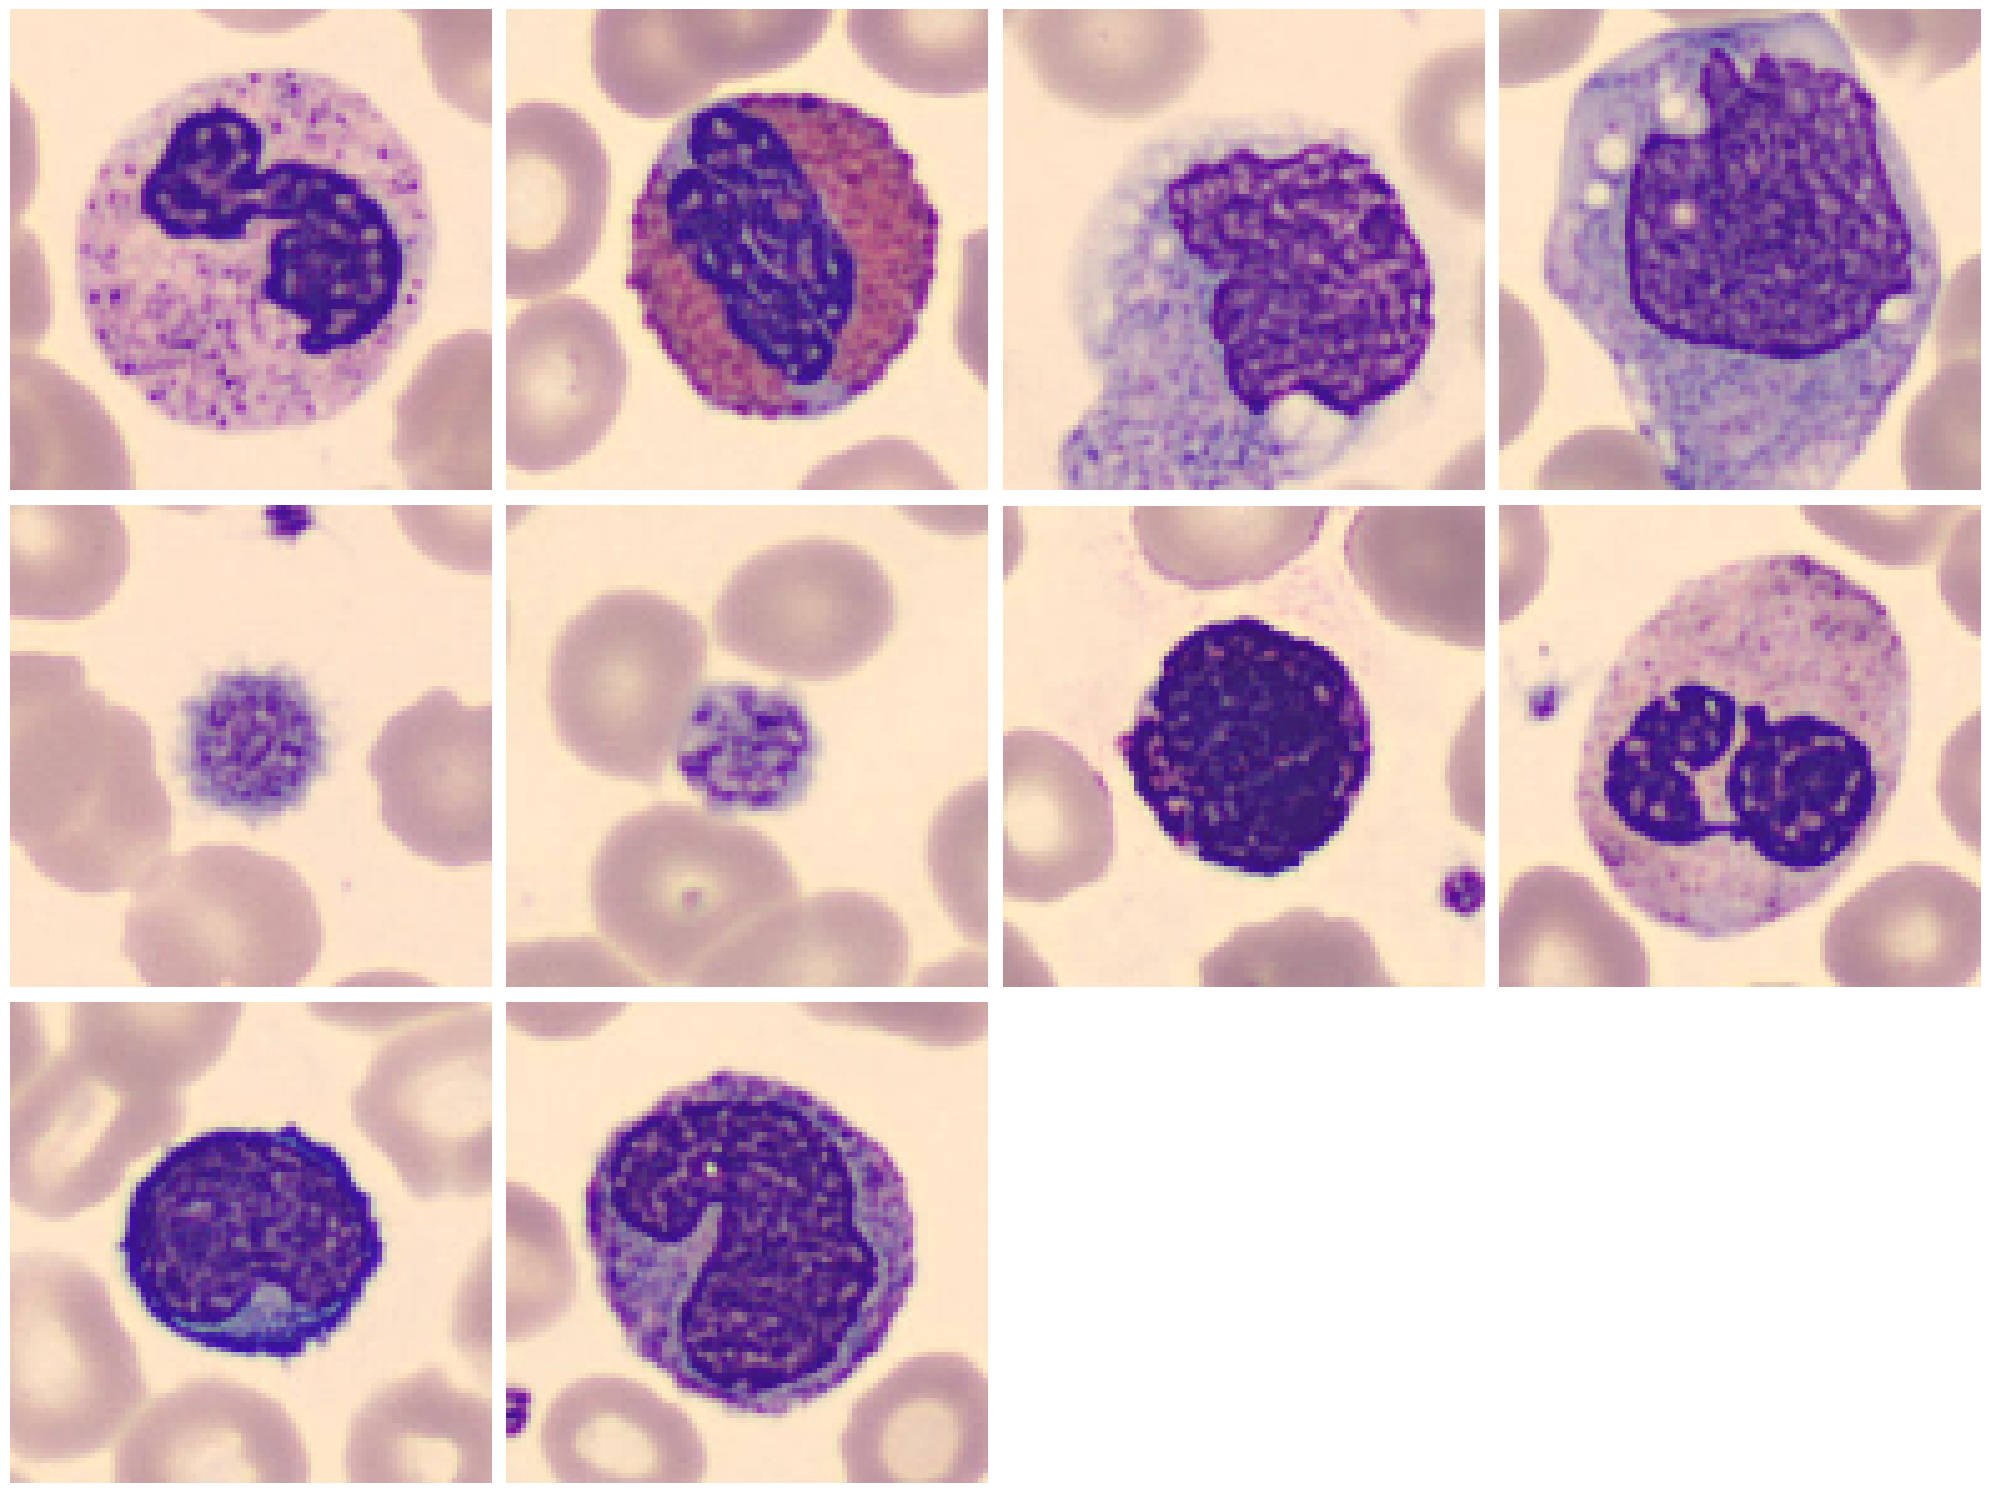

In [6]:
def plot_images_batch(images, start_index=0, batch_size=200):
    # Craft a batch of images
    end_index = min(start_index + batch_size, len(images))
    images_batch = images[start_index:end_index]

    # Create a layout for better plotting
    num_images = len(images_batch)
    grid_size = int(np.ceil(np.sqrt(num_images)))

    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images_batch[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_images_batch(X, start_index=20, batch_size=10)

## 🚆 Split into train, validation and train sets

In [ ]:
# Split the dataset into a training + validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    stratify=y,
    random_state=seed)

# Further split the training + validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=len(X_test),
    stratify=y_train_val,
    random_state=seed)

# Convert labels to one-hot encoding
y_train = tfk.utils.to_categorical(y_train, 8)
y_val = tfk.utils.to_categorical(y_val, 8)
y_test = tfk.utils.to_categorical(y_test, 8)

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)

Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


## 🧮 Define Network Parameters

In [8]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print('Input shape:\t', input_shape)
print('Output shape:\t', output_shape)

# Number of training epochs
epochs = 100

# Number of samples passed to the network at each training step
batch_size = 64

learning_rate = 1e-5

# L2 Lambda for regularization
l2_lambda = 1e-5

Input shape:	 (96, 96, 3)
Output shape:	 8


In [18]:
# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True
)

# Create a LearningRate Scheduler, which reduces learning rate if val loss doesn't improve
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5
)

# Store the callback in a list
callbacks = [early_stopping, lr_scheduler]

## 🔨 Import and tune the Model

In [ ]:
# Import and initialize ResNet50V2
model = tfk.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg',
    classes=output_shape,
)

# Freeze all layers to use the model solely as a feature extractor
model.trainable = False

# Create input layer
inputs = tfkl.Input(shape=input_shape)

# Initialize regularizer
regularizer = tfk.regularizers.L2(l2_lambda)

# Connect model with inputs
x = model(inputs)

# Add layers
x = tfkl.BatchNormalization()(x)
x = tfkl.Dense(units=512, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.5)(x)
x = tfkl.Dense(units=256, activation='relu', kernel_regularizer=regularizer)(x)
x = tfkl.BatchNormalization()(x)
x = tfkl.Dropout(0.3)(x)

# Setup Fully Connected Blocks
outputs = tfkl.Dense(units=output_shape, activation='softmax')(x)

# Connect input and output through the Model class
model = tfk.Model(inputs=inputs, outputs=outputs)

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 🧠 Train the Model for Transfer Learning

In [11]:
# Train the model
tl_history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
tl_final_val_accuracy = round(max(tl_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {tl_final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
tl_model_filename = 'ResNet50V2' + str(tl_final_val_accuracy) + '.keras'
model.save(tl_model_filename)

# Free memory by deleting the model instance
del model

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.2419 - loss: 2.4392 - val_accuracy: 0.4766 - val_loss: 1.5089 - learning_rate: 1.0000e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5912 - loss: 1.2284 - val_accuracy: 0.6998 - val_loss: 0.8521 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6858 - loss: 0.9062 - val_accuracy: 0.7676 - val_loss: 0.6749 - learning_rate: 1.0000e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7346 - loss: 0.7544 - val_accuracy: 0.7901 - val_loss: 0.5988 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.7685 - loss: 0.6722 - val_accuracy: 0.8010 - val_loss: 0.5593 - learning_rate: 1.0000e-05
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7929 - loss: 0.6008 - val_accuracy: 0.8102 - val_loss: 0.5349 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 35m

In [12]:
# Test Model after Transfer Learning
# Load the model
model = tfk.models.load_model(tl_model_filename)

# Make prediction on validation and test sets
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Convert predictions
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute accuracies
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

del model

38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Validation Accuracy: 0.8671
Test Accuracy: 0.8629


## 🔧 Fine Tuning

In [20]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model(tl_model_filename)

# Set the model layers as trainable
ft_model.get_layer('resnet50v2').trainable = True

# Set all layers as non-trainable
for layer in ft_model.get_layer('resnet50v2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True

In [21]:
# Set the number of layers to freeze
N = 150

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:N]):
    layer.trainable = False

# Compile the model
loss = tfk.losses.CategoricalCrossentropy()
optimizer = tfk.optimizers.Lion(learning_rate=learning_rate)
metrics = ['accuracy']
ft_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

## 🧠 Train Fine-Tuned Model

In [22]:
# Train the model
ft_history = ft_model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

print('Training finished.')

# Calculate and print the final validation accuracy
ft_final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {ft_final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
ft_model_filename = 'ResNet50V2' + str(ft_final_val_accuracy) + '.keras'
ft_model.save(ft_model_filename)
ft_model.save('weights.keras')

# Free memory by deleting the model instance
del ft_model

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 118ms/step - accuracy: 0.8425 - loss: 0.5101 - val_accuracy: 0.3261 - val_loss: 7.9698 - learning_rate: 1.0000e-05
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7575 - loss: 0.7930 - val_accuracy: 0.1288 - val_loss: 16.1828 - learning_rate: 1.0000e-05
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7908 - loss: 0.6609 - val_accuracy: 0.4766 - val_loss: 4.1995 - learning_rate: 1.0000e-05
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.8106 - loss: 0.5726 - val_accuracy: 0.4105 - val_loss: 6.0270 - learning_rate: 1.0000e-05
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8260 - loss: 0.5204 - val_accuracy: 0.2224 - val_loss: 5.3535 - learning_rate: 1.0000e-05
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8382 - loss: 0.4790 - val_accuracy: 0.4841 - val_loss: 2.2786 - learning_rate: 1.0000e-05
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms

In [23]:
# Load the model
model = tfk.models.load_model(ft_model_filename)

# Make prediction on validation and test sets
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Convert predictions
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Compute accuracies
test_accuracy = np.sum(y_test_classes == y_pred_test_classes) / len(y_test_classes)
val_accuracy = np.sum(y_val_classes == y_pred_val_classes) / len(y_val_classes)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

del model

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Validation Accuracy: 0.8871
Test Accuracy: 0.9013


## 📊 Create the model.py

In [24]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


## 📁 Export the ZIP file

In [25]:
# Set filename for the zip file
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create a zip file with the provided filename, containing model and weights
!zip {filename} model.py weights.keras

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 31%)
